In [1]:
import torch

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class NNQS(nn.Module):
    def __init__(self):
        super(NNQS, self).__init__()
        self.fc1_u = nn.Linear(1, 50)
        self.fc2_u = nn.Linear(50, 50)
        self.fc3_u = nn.Linear(50, 50)
        self.fc4_u = nn.Linear(50, 1)
        #self.fc5_u = nn.Linear(20, 20)
        #self.fc6_u = nn.Linear(20, 1)

    def forward(self, x):
        u = torch.tanh(self.fc1_u(x))
        u = torch.tanh(self.fc2_u(u))
        u = torch.tanh(self.fc3_u(u))
        #u = torch.tanh(self.fc4_u(u))
        #u = torch.tanh(self.fc5_u(u))
        u = self.fc4_u(u)
        return u

# Initialize model
model = NNQS().to(device)


In [5]:
# Ensure CUDA context initialization
if device.type == 'cuda':
    _ = torch.zeros(1, device=device)  # Force CUDA context initialization


In [6]:
x = torch.linspace(-5,5,10001).to(device)
x.requires_grad = True
if device.type == 'cuda':
    _ = torch.zeros(1, device=device)  # Force CUDA context initialization

In [7]:
x = x.reshape(-1,1)
x

tensor([[-5.0000],
        [-4.9990],
        [-4.9980],
        ...,
        [ 4.9980],
        [ 4.9990],
        [ 5.0000]], device='cuda:0', grad_fn=<ViewBackward0>)

In [8]:
x[1]-x[0]

tensor([0.0010], device='cuda:0', grad_fn=<SubBackward0>)

In [9]:
model(x)

tensor([[-0.1784],
        [-0.1784],
        [-0.1784],
        ...,
        [ 0.0162],
        [ 0.0162],
        [ 0.0162]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [10]:
def HpsiH(x,model):
    u = model(x)
    u1 = u.reshape(-1)
    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:,0]
    u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    x1 = x.reshape(-1)
    return torch.sum((-u_xx*u1+(4.0)*(x1**2)*(u1**2))**2)*0.001 + 1000*(u1[0]**2 + u1[-1]**2 + u_x[0]**2+u_x[-1]**2)

In [11]:
def normalization(x,model):
    u = model(x)
    return 1000*((torch.sum(u**2)*0.001 - torch.tensor(1.0))**2)

In [55]:
eta = 0.00001
optimizer = optim.Adam(list(model.parameters()), lr=eta)

In [57]:
for epoch in range(10000):
    E_loss = HpsiH(x,model)
    norm_loss = normalization(x,model)            
    optimizer.zero_grad()
    L_total = E_loss + norm_loss
    
    # Step 3: Backpropagate to compute gradients
    L_total.backward()
    
    # Step 4: Perform the gradient descent step
    optimizer.step()
    
    if epoch%100==99:
        print(f"epochs:{epoch+1} , Loss:{L_total}")

epochs:100 , Loss:1.5127758979797363
epochs:200 , Loss:1.512773036956787
epochs:300 , Loss:1.5127694606781006
epochs:400 , Loss:1.5127652883529663
epochs:500 , Loss:1.512760877609253
epochs:600 , Loss:1.5127556324005127
epochs:700 , Loss:1.5127500295639038
epochs:800 , Loss:1.5127439498901367
epochs:900 , Loss:1.5127376317977905
epochs:1000 , Loss:1.5127304792404175
epochs:1100 , Loss:1.5127230882644653
epochs:1200 , Loss:1.512715458869934
epochs:1300 , Loss:1.5127073526382446
epochs:1400 , Loss:1.5126988887786865
epochs:1500 , Loss:1.5126900672912598
epochs:1600 , Loss:1.5126805305480957
epochs:1700 , Loss:1.5126712322235107
epochs:1800 , Loss:1.5126618146896362
epochs:1900 , Loss:1.5126529932022095
epochs:2000 , Loss:1.512707233428955
epochs:2100 , Loss:1.5126317739486694
epochs:2200 , Loss:1.512622594833374
epochs:2300 , Loss:1.5126570463180542
epochs:2400 , Loss:1.5126041173934937
epochs:2500 , Loss:1.5126901865005493
epochs:2600 , Loss:1.5125855207443237
epochs:2700 , Loss:1.51257

In [59]:
u_pred = model(x).reshape(-1)

In [61]:
u_pred

tensor([-9.1597e-05, -9.1642e-05, -9.1732e-05,  ..., -1.4886e-05,
        -1.4797e-05, -1.4737e-05], device='cuda:0', grad_fn=<ViewBackward0>)

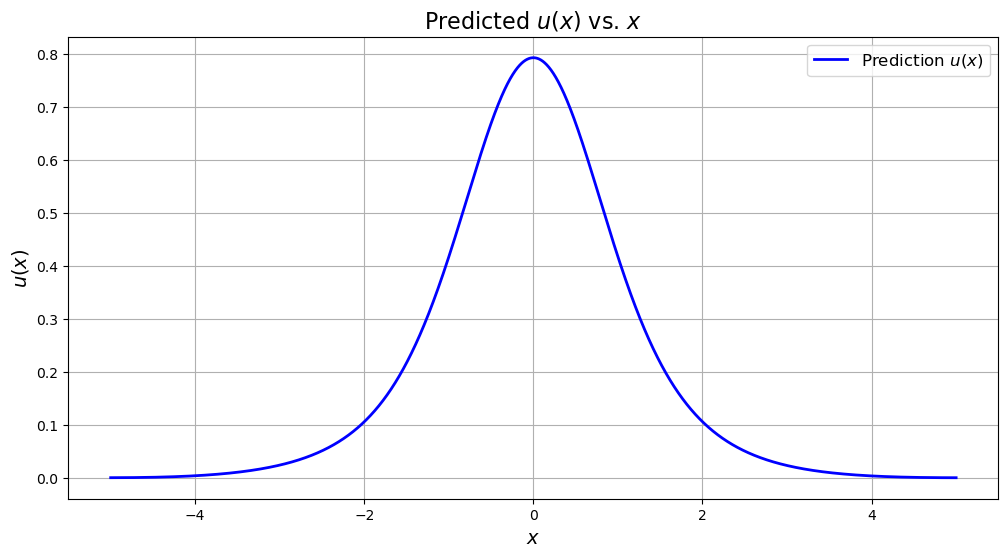

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming u_pred is already converted to a numpy array
u_pred = u_pred.detach().cpu().numpy()

# Create x_array
x_array = np.linspace(-5, 5, 10001)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x_array, -1*u_pred, label='Prediction $u(x)$', color='blue', linewidth=2)

# Add labels, title, and legend
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u(x)$', fontsize=14)
plt.title('Predicted $u(x)$ vs. $x$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


In [65]:
u = model(x)

In [67]:
HpsiH(x,model)/(torch.sum(u**2)*0.001)

tensor(1.5124, device='cuda:0', grad_fn=<DivBackward0>)

In [69]:
(torch.sum(u**2)*0.001)

tensor(0.9987, device='cuda:0', grad_fn=<MulBackward0>)

In [71]:
u = model(x)
grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
u_x = grads[:,0]
u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
u_xx = u_x_grads[:,0]

In [ ]:
A = (-u_xx + 100*(x1**2)*(u1))
A.shape

In [ ]:
A = 100*(x1**2)*(u1)
A.shape

In [ ]:
torch.sum(u**2)

In [ ]:
normalization(x,model)

In [ ]:
optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=20)

In [ ]:
for epoch in range(100):
    def closure():
        optimizer.zero_grad()

        # Compute losses
        E_loss = HpsiH(x,model)
        norm_loss = normalization(x,model)            
        L_total = E_loss + norm_loss
        
        # Backpropagation
        L_total.backward()
        return L_total

    optimizer.step(closure)

    # Print loss every 100 epochs
    if epoch % 10 == 9:
        loss = closure()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


In [73]:
u1 = u.reshape(-1)
x1 = x.reshape(-1)

In [75]:
torch.sum((-u_xx*u1+(4.0)*(x1**2)*(u1**2)))*0.001

tensor(2.4033, device='cuda:0', grad_fn=<MulBackward0>)